In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import shap
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
#import xgboost as xgb

/home/miki/Desktop/Docker/BCG/Customer-Churning-Analysis/churn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = os.path.join("/home/miki/Desktop/Docker/BCG/Customer-Churning-Analysis/data/test")
TRAINING_DATA = os.path.join(DATA_DIR, "data.pkl")
HISTORY_DATA = os.path.join(DATA_DIR, "price.pkl")

In [3]:
client_df = pd.read_pickle(TRAINING_DATA)
price_df = pd.read_pickle(HISTORY_DATA)

In [4]:
model_df = pd.merge(client_df, price_df, on="id")

In [5]:
model_df.dtypes

id                                        object
cons_12m                                 float64
cons_gas_12m                             float64
cons_last_month                          float64
forecast_cons_12m                        float64
forecast_discount_energy                 float64
forecast_meter_rent_12m                  float64
forecast_price_energy_off_peak           float64
forecast_price_energy_peak               float64
forecast_price_pow_off_peak              float64
has_gas                                    int64
imp_cons                                 float64
margin_gross_pow_ele                     float64
margin_net_pow_ele                       float64
nb_prod_act                                int64
net_margin                               float64
pow_max                                  float64
churn                                      int64
tenure                                     int64
months_activ                             float64
months_to_end       

In [6]:
pd.DataFrame({"Dataframe columns": model_df.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_off_peak
8,forecast_price_energy_peak
9,forecast_price_pow_off_peak


#### Splitting Data

In [7]:
y = model_df["churn"]
X = model_df.drop(labels = ["id","churn", "price_date"],axis = 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Modelling

In [9]:
import xgboost as xgb

In [10]:
model = xgb.XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=500,n_jobs=-1)
result = model.fit(X_train,y_train)

In [11]:
def evaluate(model_, X_test_, y_test_):
    """
    Evaluate the accuracy, precision and recall of a model
    """
    # Get the model predictions
    prediction_test_ = model_.predict(X_test_)
    # Print the evaluation metrics as pandas dataframe
    results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test_, prediction_test_)],
    "Precision" : [metrics.precision_score(y_test_, prediction_test_)],
    "Recall" : [metrics.recall_score(y_test_, prediction_test_)]})
    return results

In [12]:
evaluate(result, X_test, y_test)

,Accuracy,Precision,Recall
0,0.983671,0.99819,0.829474


In [13]:
def calculate_roc_auc(model_, X_test_, y_test_):
    """
    Evaluate the roc-auc score
    """
    # Get the model predictions
    # Note that we are using the prediction for the class 1 -> churn
    prediction_test_ = model_.predict_proba(X_test_)[:,1]
    # Compute roc-auc
    fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)
    # Print the evaluation metrics as pandas dataframe
    score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
    return fpr, tpr, score
def plot_roc_auc(fpr,tpr):
    """
    Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates.
    """
    # Initialize plot
    f, ax = plt.subplots(figsize=(14,8))
    # Plot ROC
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.3,
    label="AUC = %0.2f" % (roc_auc))
    # Plot the random line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
    label="Random", alpha=.8)
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()

In [14]:
fpr, tpr, auc_score = calculate_roc_auc(model, X_test, y_test)

In [15]:
auc_score

,ROC-AUC
0,0.999186


In [16]:
# Show plots in jupyter notebook
%matplotlib inline

In [17]:
# Set plot style
sns.set(color_codes=True)

In [18]:

# load JS visualization code to notebook
shap.initjs()

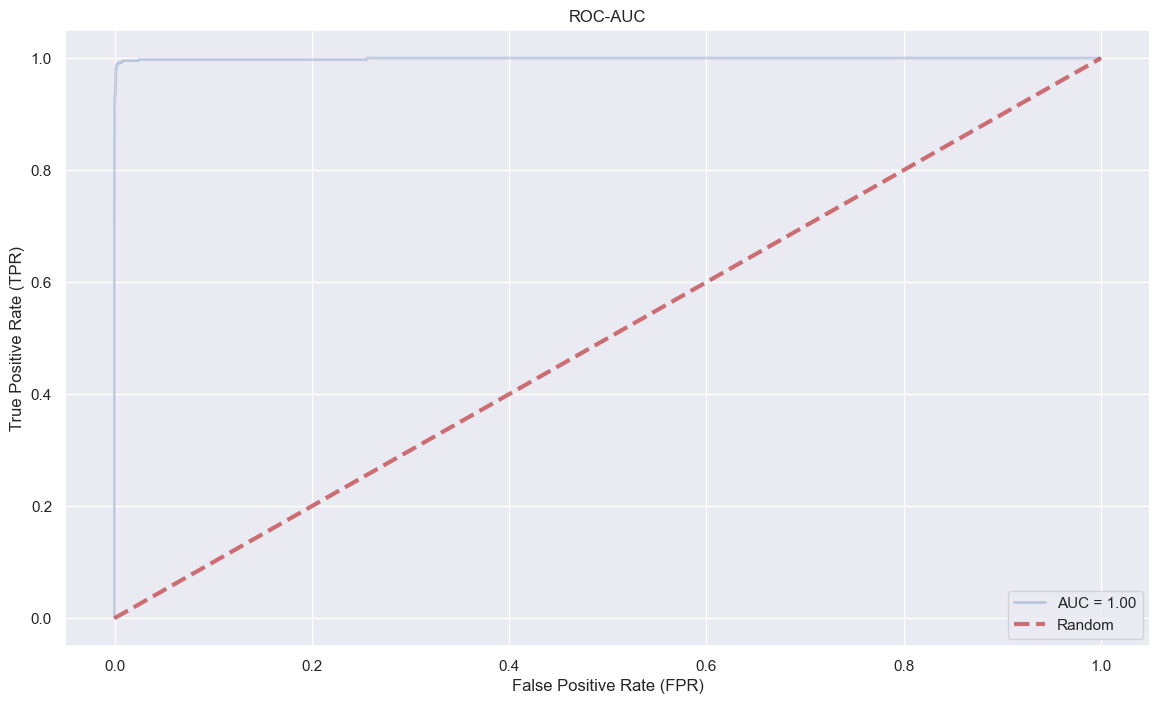

In [19]:
plot_roc_auc(fpr, tpr)
plt.show()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

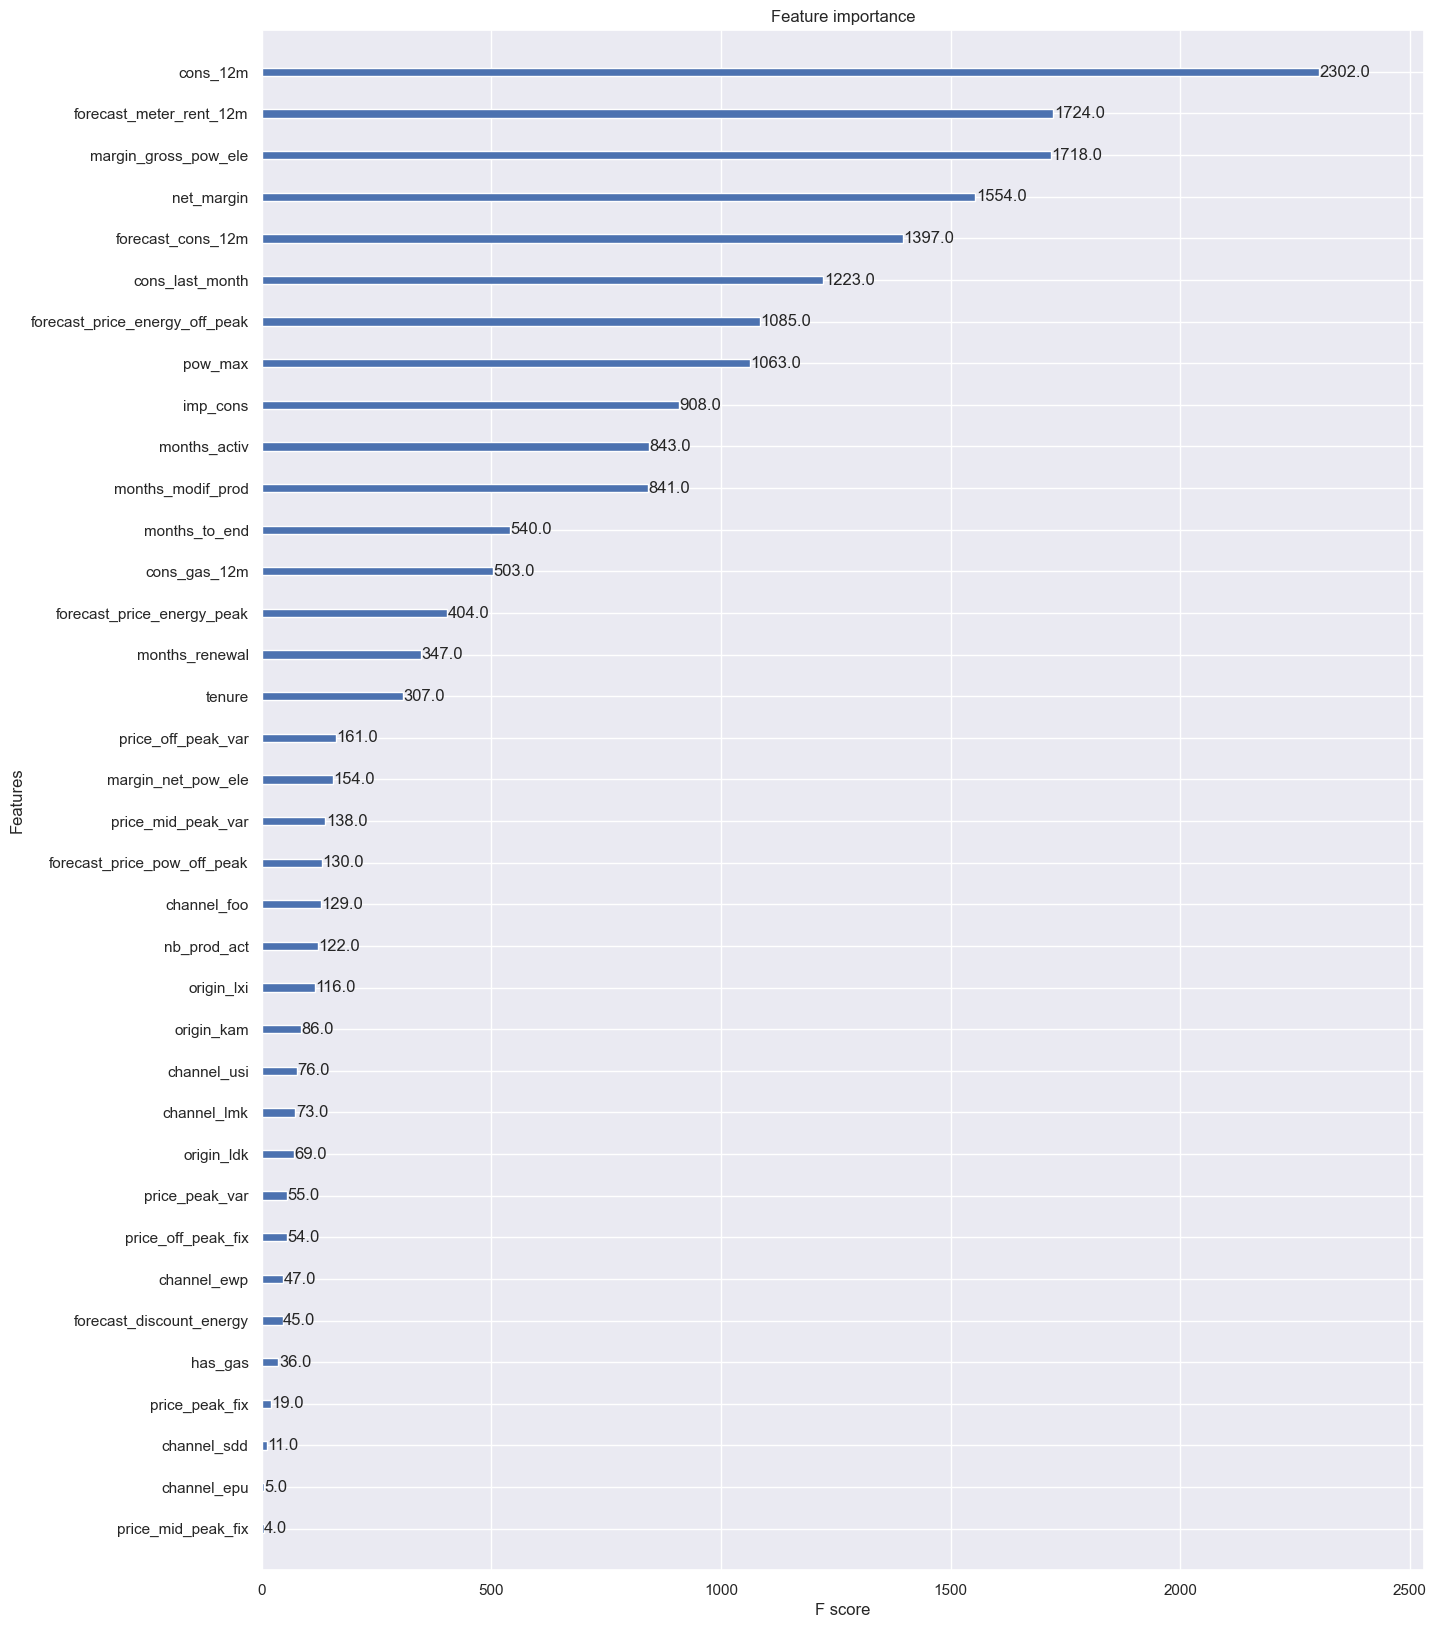

In [20]:
fig, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(result, ax=ax)

##### In the feature importance graph above we can see that cons_12m and forecast_meter_rent_12m are the features that appear the most in our model and we could infere that these two features have a signiﬁcant importnace in our model

In [21]:
explainer = shap.TreeExplainer(result)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


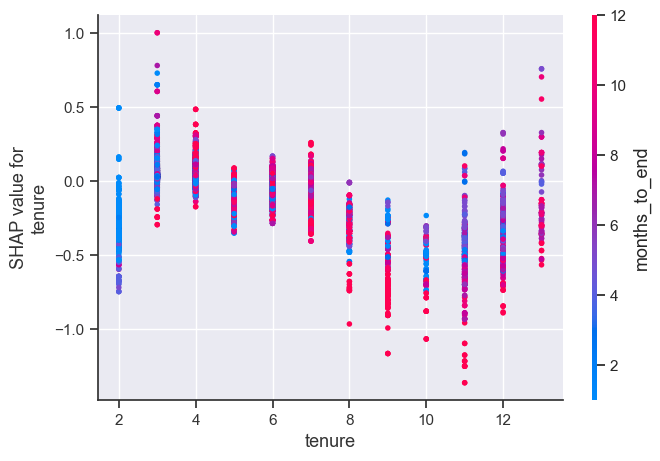

In [22]:
shap.dependence_plot("tenure", shap_values, X_test)#, interaction_index="origin_lxi")

In [23]:
shap.force_plot(explainer.expected_value, shap_values[4023], X_test.iloc[4023,:], link="logit")

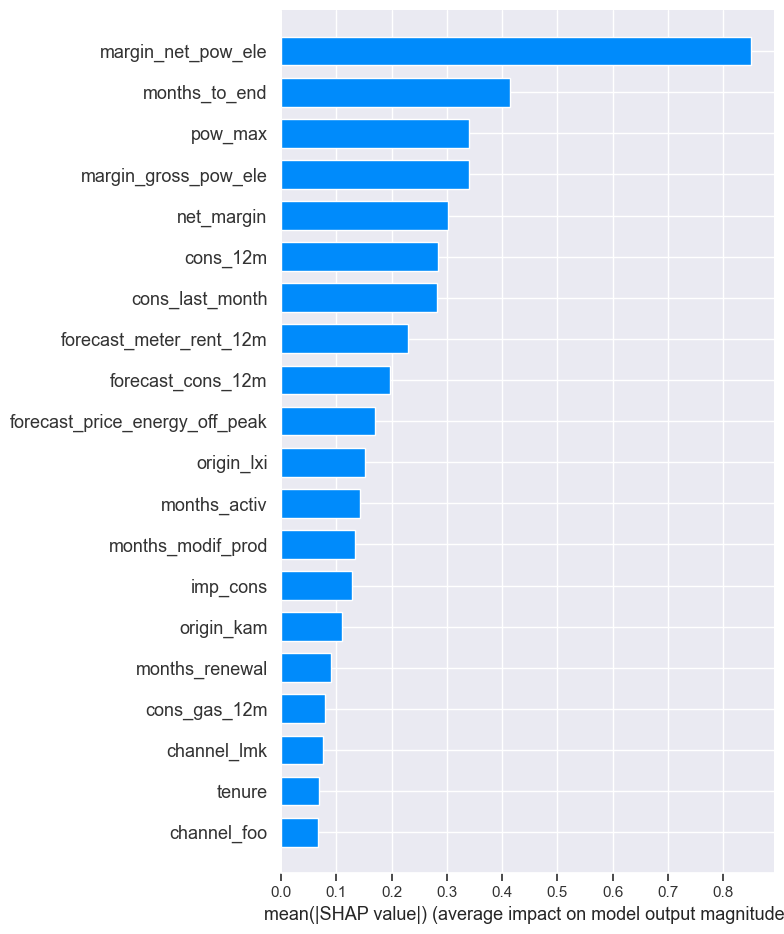

In [24]:
shap.summary_plot(shap_values, X_test, plot_type='bar')